## Regression of home prices

#### Libraries

In [1]:
# core scipy & pandas
import pandas as pd
import numpy as np
import scipy as sp

# XGboost for gradient-boosted decision trees
import xgboost as xgb

# preprocessing and linear model
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import Lasso, Ridge

# feature collapsing
from sklearn.decomposition import PCA

# statsmodels for OLS
import statsmodels.api as sm
from patsy import dmatrices

# charts
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# re
import re

/usr/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
pd.options.display.max_columns = 79

#### Load data

In [3]:
DATADIR = './Data/'
TRAIN_FILE = 'train.csv.gz'
TEST_FILE = 'test.csv.gz'

In [4]:
train_raw = pd.read_csv(DATADIR+TRAIN_FILE)
test_raw = pd.read_csv(DATADIR+TEST_FILE)

In [5]:
IDS = test_raw['Id']
del test_raw['Id']
del train_raw['Id']

#### Model testing

In [6]:
train_raw.shape

(1460, 80)

In [7]:
train_raw.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [8]:
train_raw.SaleType.value_counts()

WD       1267
New       122
COD        43
ConLD       9
ConLw       5
ConLI       5
CWD         4
Oth         3
Con         2
Name: SaleType, dtype: int64

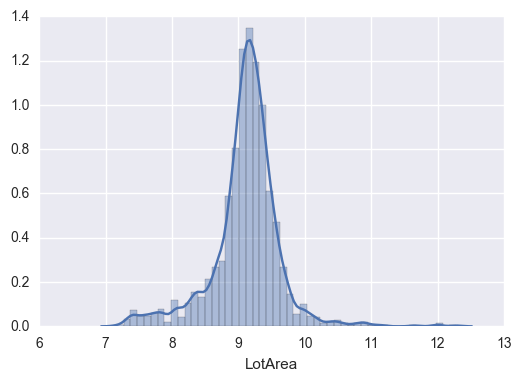

In [9]:
sns.distplot(np.log(train_raw.LotArea))

In [10]:
train_raw.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [11]:
def transforms(df):
    # log transforms
    df.LotArea = np.log(df.LotArea)
    df.GrLivArea = np.log(train_raw.GrLivArea)
    train_raw.TotalBsmtSF = np.log(train_raw.TotalBsmtSF+1e-12)
    
#     # fill missing values 
#     df.LotFrontage = df.LotFrontage.fillna(0)
#     df.GarageYrBlt = train_raw.GarageYrBlt.fillna(0)
    
    # binary encoding
    df.EnclosedPorch = df.EnclosedPorch>0
    
    # change numeric to string value
    df.YearBuilt = df.YearBuilt.astype(str)
    df.OverallQual = df.OverallQual.astype(str)
    df.OverallCond = df.OverallCond.astype(str)
    
    df = df.convert_objects(convert_numeric=True)
    return df

train_raw = transforms(train_raw)
test_raw = transforms(test_raw)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:19: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


In [12]:
newcols = []
for i, c in enumerate(train_raw.columns):
    if re.search(r'[0-9]',c[0]):
        newcols.append('_'+c)
    else:
        newcols.append(c)
train_raw.columns = newcols

In [13]:
formula = 'np.log(SalePrice) ~ '+' + '.join(train_raw.columns)

In [14]:
y, X = dmatrices(formula, data=train_raw.fillna(0), return_type='dataframe')
model = sm.OLS(y, X)
res = model.fit_regularized(L1_wt=1.0)

In [15]:
print res.aic

-3281.88252561


In [16]:
print res.rsquared_adj

0.966920932677


In [17]:
print res.summary()

                            OLS Regression Results                            
Dep. Variable:      np.log(SalePrice)   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     167.6
Date:                Sun, 25 Dec 2016   Prob (F-statistic):               0.00
Time:                        02:00:19   Log-Likelihood:                 1897.9
No. Observations:                1460   AIC:                            -3282.
Df Residuals:                    1203   BIC:                            -1923.
Df Model:                         256                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
Intercept               

In [18]:
res = model.fit()
outliers = res.outlier_test()

In [19]:
outlier_index = outliers.iloc[:,2]<=0.05

In [20]:
train_raw.loc[outlier_index,:]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,Electrical,_1stFlrSF,_2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,_3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
30,70,C (all),50.0,9.047821,Pave,Pave,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Feedr,Norm,1Fam,2Story,4,4,1920,1950,Gambrel,CompShg,BrkFace,BrkFace,None,0.0,TA,Fa,BrkTil,TA,TA,No,Unf,0,Unf,0,649,1.868015,GasA,...,SBrkr,649,668,0,7.183112,0,0,1,0,3,1,TA,6,Typ,0,NaN,Detchd,1920.0,Unf,1,250,TA,Fa,N,0,54,True,0,0,0,NaN,MnPrv,NaN,0,7,2008,WD,Normal,40000
88,50,C (all),105.0,9.044286,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,IDOTRR,Feedr,Feedr,1Fam,1.5Fin,3,2,1915,1982,Hip,CompShg,Plywood,Plywood,None,0.0,Fa,Fa,CBlock,TA,Fa,No,Unf,0,Unf,0,1013,1.934513,GasA,...,SBrkr,1013,0,513,7.330405,0,0,1,0,2,1,Fa,6,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,N,0,0,True,0,0,0,NaN,MnPrv,NaN,0,10,2009,ConLD,Abnorml,85000
197,75,RL,174.0,10.143252,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Artery,Norm,1Fam,2Story,8,4,1918,1990,Gable,CompShg,Stucco,Stucco,None,0.0,Gd,Gd,PConc,TA,TA,No,GLQ,1036,LwQ,184,140,1.976195,GasA,...,SBrkr,1360,1360,392,8.043021,1,1,2,0,4,1,Gd,8,Typ,1,Ex,Detchd,1918.0,Unf,2,795,TA,TA,Y,0,16,True,0,0,512,Ex,GdPrv,NaN,0,3,2006,WD,Abnorml,235000
462,20,RL,60.0,9.021719,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,1Fam,1Story,5,5,1965,1965,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,553,BLQ,311,0,1.911256,GasA,...,SBrkr,864,0,0,6.761573,0,0,1,0,3,1,TA,5,Typ,1,Po,Detchd,1965.0,Unf,1,360,TA,TA,Y,0,0,True,0,0,0,NaN,GdWo,NaN,0,12,2009,WD,Normal,62383
495,30,C (all),60.0,8.971956,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,4,5,1920,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,495,Unf,0,225,1.883921,GasA,...,FuseA,720,0,0,6.579251,0,0,1,0,2,1,TA,4,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,N,0,523,True,0,0,0,NaN,GdWo,NaN,0,11,2009,WD,Abnorml,34900
523,60,RL,130.0,10.598982,Pave,NaN,IR1,Bnk,AllPub,Inside,Gtl,Edwards,PosN,PosN,1Fam,2Story,10,5,2007,2008,Hip,CompShg,CemntBd,CmentBd,Stone,762.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,2260,Unf,0,878,2.085839,GasA,...,SBrkr,3138,1538,0,8.450198,1,0,3,1,3,1,Ex,11,Typ,1,Gd,BuiltIn,2007.0,Fin,3,884,TA,TA,Y,208,406,False,0,0,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750
557,50,C (all),60.0,9.309280,Pave,NaN,Reg,Low,AllPub,Inside,Mod,IDOTRR,Norm,Norm,1Fam,1.5Fin,4,6,1920,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,637,Unf,0,0,1.865129,GasA,...,SBrkr,897,439,0,7.197435,0,0,1,1,3,1,TA,7,Typ,0,NaN,CarPort,1994.0,Unf,1,570,TA,TA,Y,0,47,True,0,0,0,NaN,NaN,NaN,0,9,2006,COD,Normal,108000
632,20,RL,85.0,9.384294,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,7,5,1977,1977,Hip,CompShg,Plywood,Plywood,BrkFace,209.0,TA,Gd,CBlock,TA,TA,No,ALQ,822,Unf,0,564,1.978817,GasA,...,SBrkr,1411,0,0,7.252054,0,0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1977.0,Fin,2,544,TA,TA,Y,192,0,False,0,0,0,NaN,NaN,NaN,0,4,2009,WD,Family,82500
691,60,RL,104.0,9.977435,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,6,1994,1995,Gable,WdShngl,HdBoard,HdBoard,BrkFace,1170.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,1455,Unf,0,989,2.054302,GasA,...,SBrkr,2444,1872,0,8.370084,0,1,3,1,4,1,Ex,10,Typ,2,Ex,Attchd,1994.0,Fin,3,832,TA,TA,Y,382,50,False,0,0,0,NaN,NaN,NaN,0,1,2007,WD,Normal,755000
825,20,RL,114.0,9.602585,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,PosN,P

In [21]:
# remove outliers
train_raw = train_raw.loc[~outlier_index,:]

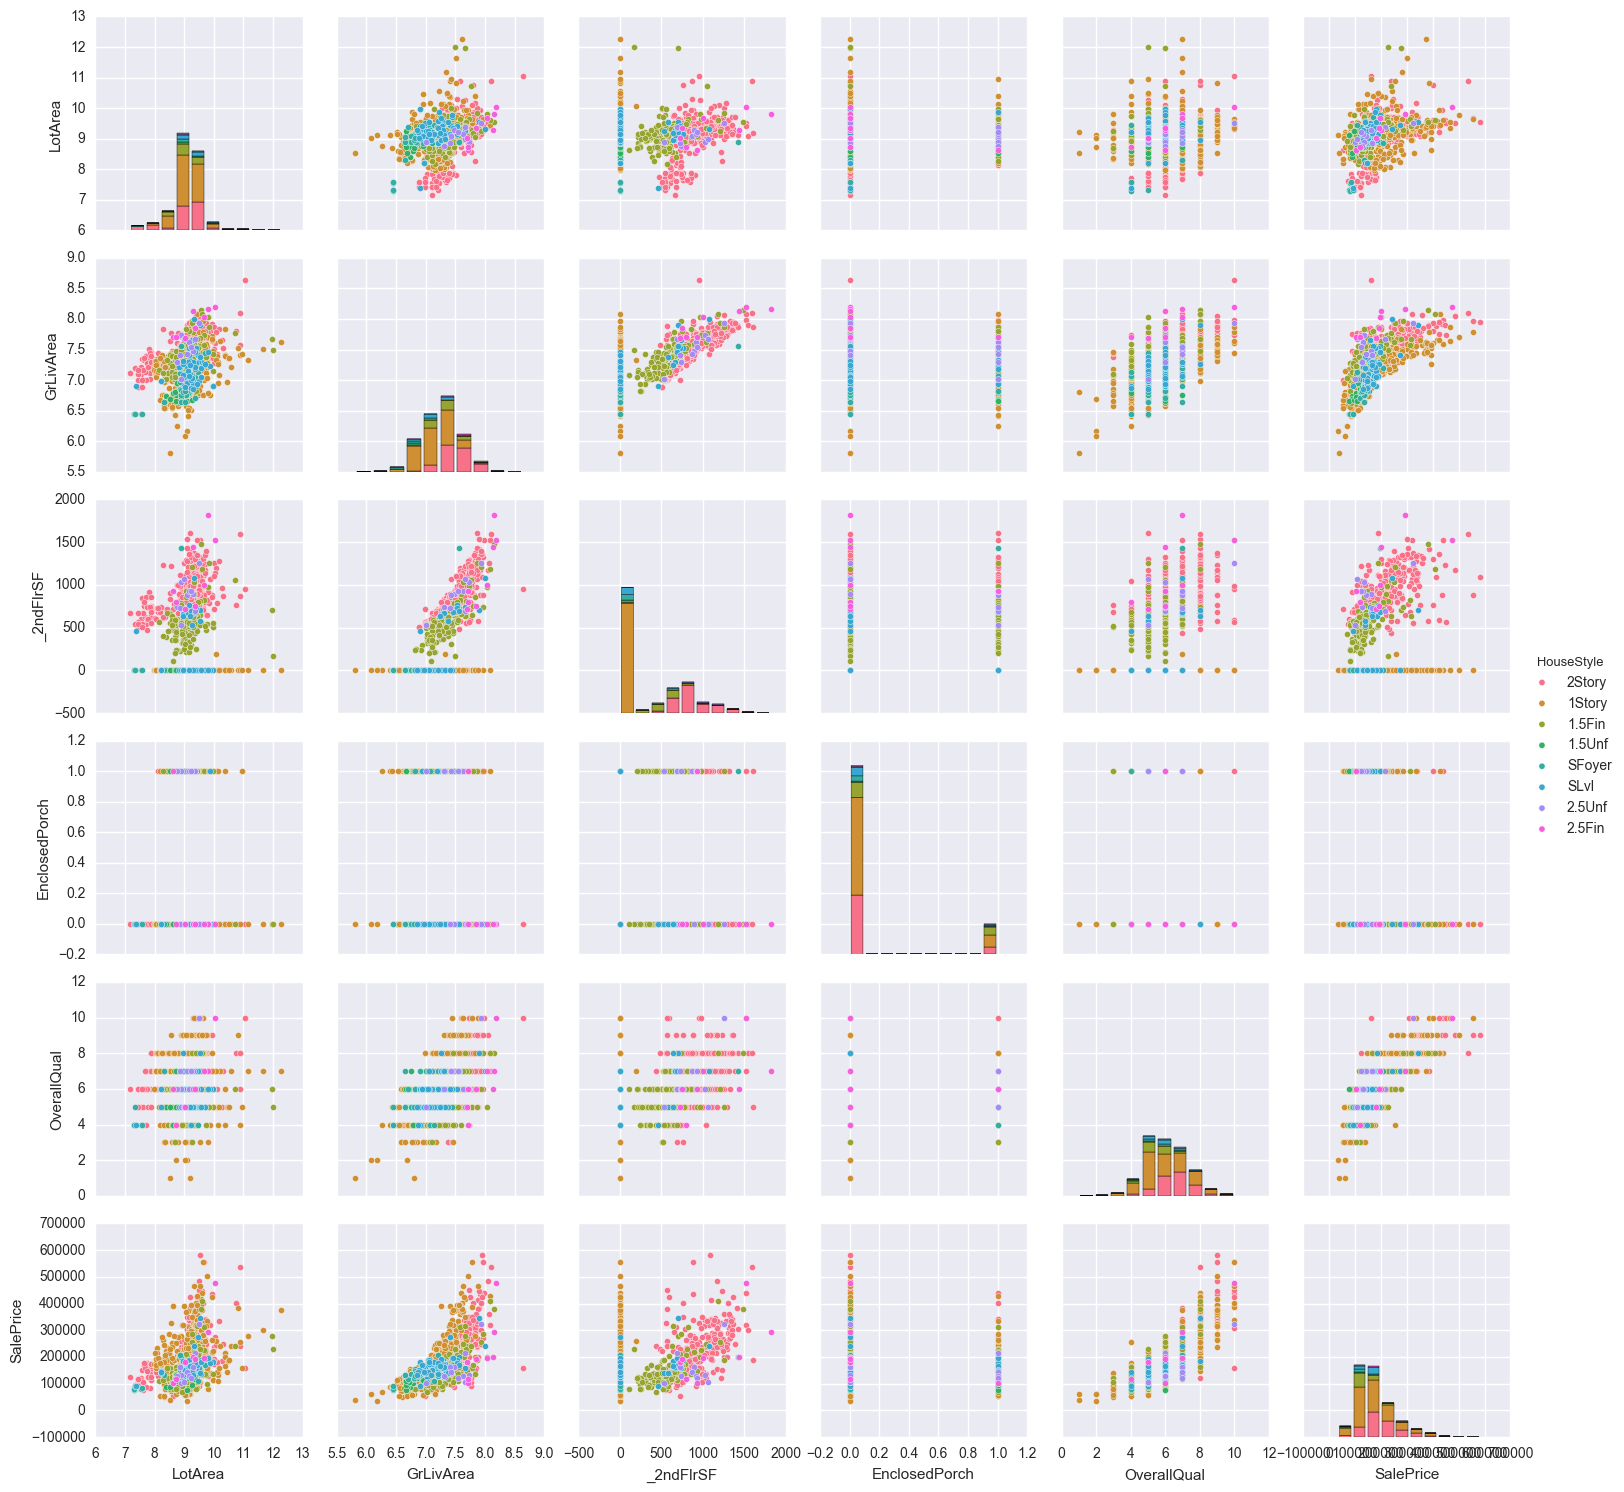

In [22]:
cols = [
    'LotArea'
    ,'GrLivArea'
    ,'_2ndFlrSF'
    ,'EnclosedPorch'
    ,'OverallQual'
    ,'HouseStyle'
]
sns.pairplot(pd.concat((train_raw[cols],
                        train_raw.SalePrice),
                       axis=1),
            hue='HouseStyle')

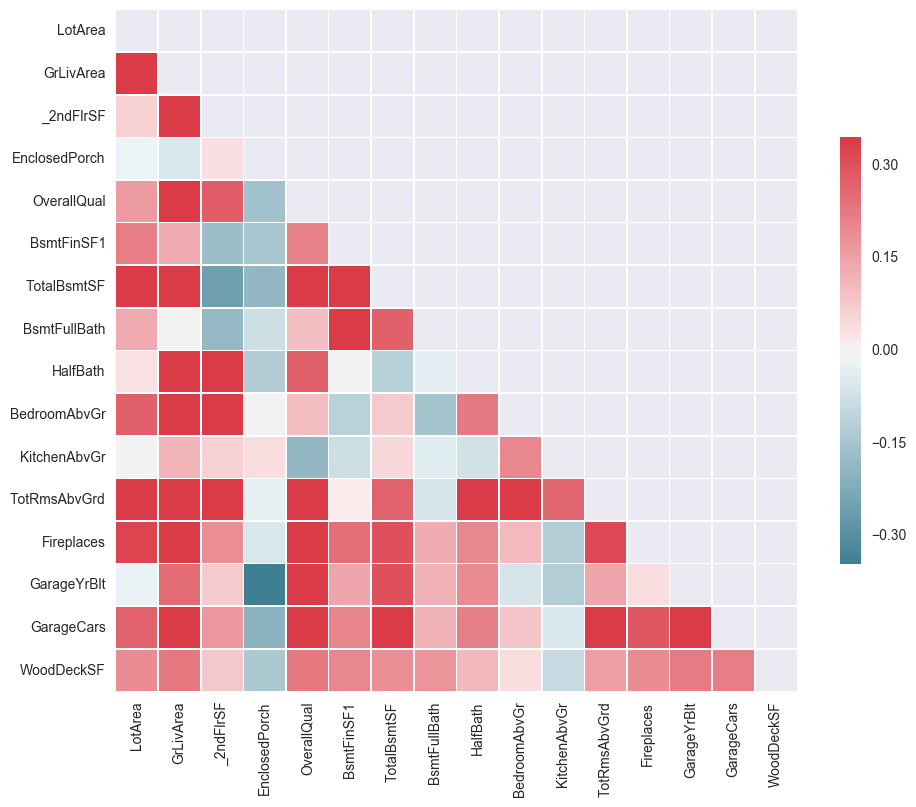

In [23]:
cols = [
    'LotArea'
    ,'GrLivArea'
    ,'_2ndFlrSF'
    ,'EnclosedPorch'
    ,'OverallQual'
    ,'BsmtFinSF1'
    ,'TotalBsmtSF'
    ,'BsmtFullBath'
    ,'HalfBath'
    ,'BedroomAbvGr'
    ,'KitchenAbvGr'
    ,'TotRmsAbvGrd'
    ,'Fireplaces'
    ,'GarageYrBlt'
    ,'GarageCars'
    ,'WoodDeckSF'
]
# Compute the correlation matrix
corr = train_raw[cols].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 11))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

#### Create one-hot representation 

In [24]:
dtypes = train_raw.dtypes
categoricals = []
for i, f in enumerate(train_raw.columns):
    if train_raw.dtypes[f] == np.dtype('O'):
        le = LabelEncoder()
        concat = (train_raw[f],test_raw[f])
        le.fit(np.hstack(concat))
        train_raw[f] = le.transform(train_raw[f])
        test_raw[f] = le.transform(test_raw[f])
        categoricals.append(i)

/usr/local/lib/python2.7/site-packages/numpy/lib/arraysetops.py:200: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))
/usr/local/lib/python2.7/site-packages/numpy/lib/arraysetops.py:259: FutureWarning: numpy equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  return aux[:-1][aux[1:] == aux[:-1]]


In [25]:
train_raw = train_raw.fillna(0)
test_raw = test_raw.fillna(0)
ohe = OneHotEncoder(categorical_features=categoricals)
cols = [col for col in train_raw.columns if col not in ['SalePrice']]
ohe.fit(np.vstack((train_raw.loc[:,cols], test_raw)))
X = ohe.transform(train_raw.loc[:,cols])
X_test = ohe.transform(test_raw)

#### Scale data

In [26]:
ss = StandardScaler(copy=True)
X = ss.fit_transform(X.A)
X_test = ss.transform(X_test.A)

In [27]:
# Y = train_raw['SalePrice'].as_matrix()
Y = np.log(train_raw['SalePrice'].as_matrix())

#### PCA

In [28]:
pca = PCA()
pca.fit(X)
f = 5
X_pca = pca.transform(X)
X_test_pca = pca.transform(X_test)
X = np.hstack((X,X_pca[:,:f]))
X_test = np.hstack((X_test,X_test_pca[:,:f]))

#### Train-test split

In [29]:
# X_train, X_val, y_train, y_val = train_test_split( X, Y, test_size=0.25)
X_train, X_val, y_train, y_val = X[:1000], X[1000:], Y[:1000], Y[1000:]

In [30]:
dtrain = xgb.DMatrix( X, label=Y )
# dval = xgb.DMatrix( X_val, label=y_val )
dtest = xgb.DMatrix( X_test )

#### Boosted trees model 

In [43]:
param = {
    'seed': 0,
    'colsample_bytree': 0.7,
    'silent': 1,
    'subsample': 0.7,
    'learning_rate': 0.075,
    'objective': 'reg:linear',
    'max_depth': 4,
    'num_parallel_tree': 1,
    'min_child_weight': 1,
    'eval_metric': 'rmse',
    'nrounds': 500
}
param['nthread'] = 2
res = xgb.cv(param.items(), 
             dtrain, 
             num_boost_round=t+1, 
             nfold=4, 
             verbose_eval=t//10,
             early_stopping_rounds=25, 
             show_stdv=True)

[0]	train-rmse:10.6694+0.00311184	test-rmse:10.6694+0.0100554
[500]	train-rmse:0.0186935+0.000527148	test-rmse:0.109496+0.00770591


In [ ]:
best_nrounds = res.shape[0] - 1
xgb_model = xgb.train(param.items(), dtrain, best_nrounds)

#### Re-predict with full dataset

In [ ]:
dtrain = xgb.DMatrix( X, label=Y )
xgb_model = xgb.train(param.items(), dtrain, t+1)
predictions = xgb_model.predict(dtest)

In [ ]:
submission = pd.DataFrame(np.vstack((IDS.astype(str), 
                                     np.exp(predictions))).T,
                          columns=['Id','SalePrice'])
submission.to_csv('submission.csv', index=False)